## **Non-Personalized Recommenders**

### We will use the Movielens 10 million dataset. We download it and uncompress the file we need.

### In order to reuse it in the future, we will put all of that in a class that we can call easily

In [17]:
from urllib.request import urlretrieve
import zipfile, os

In [18]:
# If file exists, skip the download
data_file_path = "Data_manager_split_datasets/Movielens10M/"
data_file_name = data_file_path + "movielens_10m.zip"

# If directory does not exist, create
if not os.path.exists(data_file_path):
    os.makedirs(data_file_path)

if not os.path.exists(data_file_name):
    urlretrieve ("http://files.grouplens.org/datasets/movielens/ml-10m.zip", data_file_name)

In [19]:
dataFile = zipfile.ZipFile(data_file_path + "movielens_10m.zip")

URM_path = dataFile.extract("ml-10M100K/ratings.dat", path = data_file_path + "decompressed/")

URM_file = open(URM_path, 'r')

In [20]:
type(URM_file)

_io.TextIOWrapper

#### Let's take a look at the data

In [21]:
import pandas as pd

In [22]:
URM_all_dataframe = pd.read_csv(filepath_or_buffer=URM_path, 
                                sep="::", 
                                header=None, 
                                dtype={0:int, 1:int, 2:float, 3:int},
                                engine='python')

URM_all_dataframe.columns = ["UserID", "ItemID", "Interaction", "Timestamp"]

In [23]:
URM_all_dataframe.head(n=10)

,UserID,ItemID,Interaction,Timestamp
0,1,122,5.0,838985046
1,1,185,5.0,838983525
2,1,231,5.0,838983392
3,1,292,5.0,838983421
4,1,316,5.0,838983392
5,1,329,5.0,838983392
6,1,355,5.0,838984474
7,1,356,5.0,838983653
8,1,362,5.0,838984885
9,1,364,5.0,838983707


In [24]:
print ("The number of interactions is {}".format(len(URM_all_dataframe)))

The number of interactions is 10000054


### We can use this data to create a sparse matrix, notice that we have red UserID and ItemID as int
### This is not always possible if the IDs are alphanumeric

### Now we can extract the list of unique user id and item id and display some statistics

In [25]:
userID_unique = URM_all_dataframe["UserID"].unique()
itemID_unique = URM_all_dataframe["ItemID"].unique()

In [26]:
n_users = len(userID_unique)
n_items = len(itemID_unique)
n_interactions = len(URM_all_dataframe)

print ("Number of items\t {}, Number of users\t {}".format(n_items, n_users))
print ("Max ID items\t {}, Max Id users\t {}\n".format(max(itemID_unique), max(userID_unique)))

Number of items	 10677, Number of users	 69878
Max ID items	 65133, Max Id users	 71567



### See that the max ID of items and users is higher than the number of unique values -> empty profiles
### We should remove empty indices, to do so we create a new mapping

In [27]:
user_original_ID_to_index_dict = {}

for user_id in userID_unique:
    user_original_ID_to_index_dict[user_id] = len(user_original_ID_to_index_dict)

In [28]:
item_original_ID_to_index_dict = {}

for item_id in itemID_unique:
    item_original_ID_to_index_dict[item_id] = len(item_original_ID_to_index_dict)

In [29]:
original_item_ID = 292
print("New index for item {} is {}".format(original_item_ID, item_original_ID_to_index_dict[original_item_ID]))

New index for item 292 is 3


### We now replace the IDs in the dataframe and we are ready to use the data

In [30]:
URM_all_dataframe["UserID"] = [user_original_ID_to_index_dict[user_original] for user_original in
                                      URM_all_dataframe["UserID"].values]

URM_all_dataframe["ItemID"] = [item_original_ID_to_index_dict[item_original] for item_original in 
                                      URM_all_dataframe["ItemID"].values]

In [31]:
URM_all_dataframe.head(n=10)

,UserID,ItemID,Interaction,Timestamp
0,0,0,5.0,838985046
1,0,1,5.0,838983525
2,0,2,5.0,838983392
3,0,3,5.0,838983421
4,0,4,5.0,838983392
5,0,5,5.0,838983392
6,0,6,5.0,838984474
7,0,7,5.0,838983653
8,0,8,5.0,838984885
9,0,9,5.0,838983707


In [32]:
userID_unique = URM_all_dataframe["UserID"].unique()
itemID_unique = URM_all_dataframe["ItemID"].unique()

n_users = len(userID_unique)
n_items = len(itemID_unique)
n_interactions = len(URM_all_dataframe)

print ("Number of items\t {}, Number of users\t {}".format(n_items, n_users))
print ("Max ID items\t {}, Max Id users\t {}\n".format(max(itemID_unique), max(userID_unique)))
print ("Average interactions per user {:.2f}".format(n_interactions/n_users))
print ("Average interactions per item {:.2f}\n".format(n_interactions/n_items))

print ("Sparsity {:.2f} %".format((1-float(n_interactions)/(n_items*n_users))*100))


Number of items	 10677, Number of users	 69878
Max ID items	 10676, Max Id users	 69877

Average interactions per user 143.11
Average interactions per item 936.60

Sparsity 98.66 %


##### Rating distribution in time

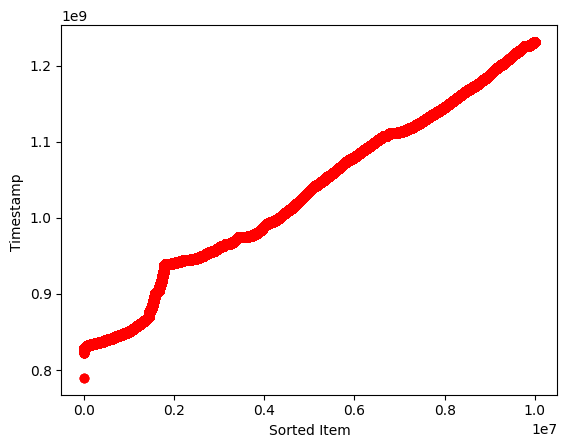

In [33]:
import matplotlib.pyplot as pyplot

# Clone the list to avoid changing the ordering of the original data
timestamp_sorted = list(URM_all_dataframe["Timestamp"].values)
timestamp_sorted.sort()


pyplot.plot(timestamp_sorted, 'ro')
pyplot.ylabel('Timestamp ')
pyplot.xlabel('Sorted Item')
pyplot.show()

#### To store the data we use a sparse matrix. We build it as a COO matrix and then change its format

#### The COO constructor expects (data, (row, column))

In [34]:
import scipy.sparse as sps

URM_all = sps.coo_matrix((URM_all_dataframe["Interaction"].values, 
                          (URM_all_dataframe["UserID"].values, URM_all_dataframe["ItemID"].values)))

URM_all

<69878x10677 sparse matrix of type '<class 'numpy.float64'>'
	with 10000054 stored elements in COOrdinate format>

In [35]:
URM_all.tocsr()

<69878x10677 sparse matrix of type '<class 'numpy.float64'>'
	with 10000054 stored elements in Compressed Sparse Row format>

### We compute the item popularity as the number of interaction in each column

### We can use the properties of sparse matrices in CSC format

In [36]:
import numpy as np

item_popularity = np.ediff1d(URM_all.tocsc().indptr)
item_popularity

array([ 2412, 14975, 17851, ...,     1,     1,     1])

In [37]:
item_popularity = np.sort(item_popularity)
item_popularity

array([    1,     1,     1, ..., 33668, 34457, 34864])

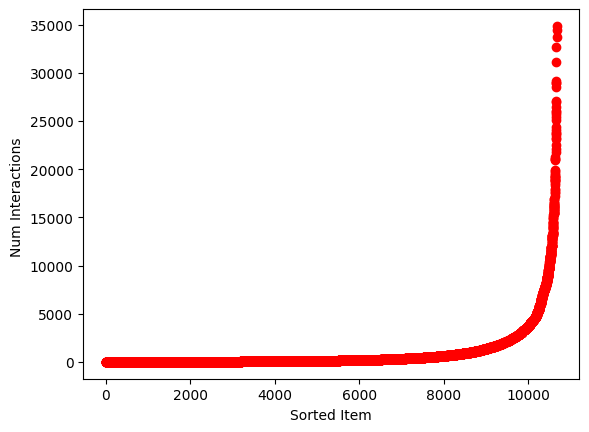

In [38]:
pyplot.plot(item_popularity, 'ro')
pyplot.ylabel('Num Interactions ')
pyplot.xlabel('Sorted Item')
pyplot.show()

In [39]:
ten_percent = int(n_items/10)

print("Average per-item interactions over the whole dataset {:.2f}".
      format(item_popularity.mean()))

print("Average per-item interactions for the top 10% popular items {:.2f}".
      format(item_popularity[-ten_percent:].mean()))

print("Average per-item interactions for the least 10% popular items {:.2f}".
      format(item_popularity[:ten_percent].mean()))

print("Average per-item interactions for the median 10% popular items {:.2f}".
      format(item_popularity[int(n_items*0.45):int(n_items*0.55)].mean()))

Average per-item interactions over the whole dataset 936.60
Average per-item interactions for the top 10% popular items 6479.52
Average per-item interactions for the least 10% popular items 5.23
Average per-item interactions for the median 10% popular items 136.45


In [40]:
print("Number of items with zero interactions {}".
      format(np.sum(item_popularity==0)))

Number of items with zero interactions 0


### We compute the user activity (profile length) as the number of interaction in each row

### We can use the properties of sparse matrices in CSR format

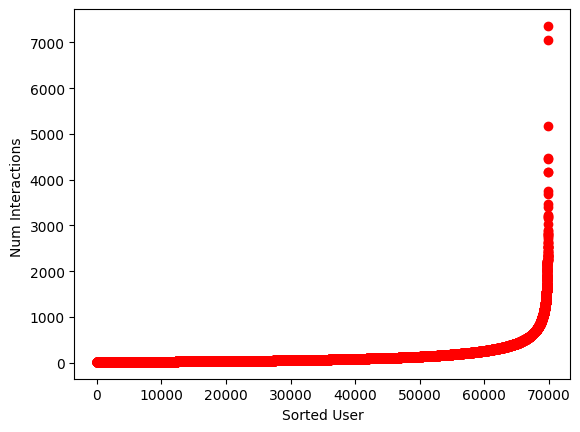

In [41]:
user_activity = np.ediff1d(URM_all.tocsr().indptr)
user_activity = np.sort(user_activity)


pyplot.plot(user_activity, 'ro')
pyplot.ylabel('Num Interactions ')
pyplot.xlabel('Sorted User')
pyplot.show()

### In order to evaluate our recommender we have to define:
* A splitting of the data in URM_train and URM_test
* An evaluation metric
* A functon computing the evaluation for each user

### The splitting of the data is very important to ensure your algorithm is evaluated in a realistic scenario by using test it has never seen. We create two splits:
#### - Train data: we will use this to train our model
#### - Test data: we will use this to evaluate our model

In [42]:
train_test_split = 0.80

n_interactions = URM_all.nnz


train_mask = np.random.choice([True,False], n_interactions, p=[train_test_split, 1-train_test_split])
train_mask

array([ True,  True,  True, ...,  True,  True,  True])

In [43]:
URM_train = sps.csr_matrix((URM_all.data[train_mask],
                            (URM_all.row[train_mask], URM_all.col[train_mask])))

URM_train

<69878x10677 sparse matrix of type '<class 'numpy.float64'>'
	with 8000095 stored elements in Compressed Sparse Row format>

In [44]:
test_mask = np.logical_not(train_mask)

URM_test = sps.csr_matrix((URM_all.data[test_mask],
                            (URM_all.row[test_mask], URM_all.col[test_mask])))

URM_test

<69878x10675 sparse matrix of type '<class 'numpy.float64'>'
	with 1999959 stored elements in Compressed Sparse Row format>

### Evaluation metric

#### We call items in the test set 'relevant'

In [81]:
user_id = 124
relevant_items = URM_test[user_id].indices
relevant_items

array([   8,   27,   29,   31,   47,   79,   93,  101,  137,  177,  181,
        225,  340,  382,  394,  406, 1079, 1314, 1466, 1469, 1496, 1603,
       2092])

#### Say that we have a recommendation list such as this

In [46]:
recommended_items = np.array([241, 1622, 15, 857, 5823])
recommended_items

array([ 241, 1622,   15,  857, 5823])

In [47]:
is_relevant = np.in1d(recommended_items, relevant_items, assume_unique=True)
is_relevant

array([False, False, False, False, False])

### Precision: how many of the recommended items are relevant

In [48]:
def precision(recommended_items, relevant_items):
    
    is_relevant = np.in1d(recommended_items, relevant_items, assume_unique=True)
    
    precision_score = np.sum(is_relevant, dtype=np.float32) / len(is_relevant)
    
    return precision_score

### Recall: how many of the relevant items I was able to recommend

In [49]:
def recall(recommended_items, relevant_items):
    
    is_relevant = np.in1d(recommended_items, relevant_items, assume_unique=True)
    
    recall_score = np.sum(is_relevant, dtype=np.float32) / relevant_items.shape[0]
    
    return recall_score

### Mean Average Precision

In [50]:
def MAP(recommended_items, relevant_items):
   
    is_relevant = np.in1d(recommended_items, relevant_items, assume_unique=True)
    
    # Cumulative sum: precision at 1, at 2, at 3 ...
    p_at_k = is_relevant * np.cumsum(is_relevant, dtype=np.float32) / (1 + np.arange(is_relevant.shape[0]))
    
    map_score = np.sum(p_at_k) / np.min([relevant_items.shape[0], is_relevant.shape[0]])

    return map_score

### Now that we have the data, we can build our first recommender. We need two things:
* a 'fit' function to train our model
* a 'recommend' function that uses our model to recommend

### Let's start with a random recommender

#### In a random recommend we don't have anything to learn from the data

In [51]:
class RandomRecommender(object):

    def fit(self, URM_train):
           
        self.n_items = URM_train.shape[1]
    
    
    def recommend(self, user_id, at=5):
    
        recommended_items = np.random.choice(self.n_items, at)

        return recommended_items

In [53]:
randomRecommender = RandomRecommender()
randomRecommender.fit(URM_train)

for user_id in range(10):
    print(randomRecommender.recommend(user_id, at=5))

[1103 1916 5582 1276 8965]
[ 4373  4642 10566  3705  8534]
[1862 7064 1629  102 9664]
[ 407 2397 1892  552 7232]
[3529 6495 3492 1030 3575]
[7640 9982 5570 7976 9863]
[ 6351   749  4559 10627  4775]
[8332 6535  106 1044 6468]
[5897 4900 9191 3555 7830]
[1038 1830 6424 5596  951]


### Put all together in an evaluation function and let's test it!

In [54]:
# We pass as paramether the recommender class

def evaluate_algorithm(URM_test, recommender_object, at=5):
    
    cumulative_precision = 0.0
    cumulative_recall = 0.0
    cumulative_MAP = 0.0
    
    num_eval = 0


    for user_id in range(URM_test.shape[0]):

        relevant_items = URM_test.indices[URM_test.indptr[user_id]:URM_test.indptr[user_id+1]]
        
        if len(relevant_items)>0:
            
            recommended_items = recommender_object.recommend(user_id, at=at)
            num_eval+=1

            cumulative_precision += precision(recommended_items, relevant_items)
            cumulative_recall += recall(recommended_items, relevant_items)
            cumulative_MAP += MAP(recommended_items, relevant_items)
            
    cumulative_precision /= num_eval
    cumulative_recall /= num_eval
    cumulative_MAP /= num_eval
    
    print("Recommender results are: Precision = {:.4f}, Recall = {:.4f}, MAP = {:.4f}".format(
        cumulative_precision, cumulative_recall, cumulative_MAP)) 


In [55]:
evaluate_algorithm(URM_test, randomRecommender)

Recommender results are: Precision = 0.0027, Recall = 0.0004, MAP = 0.0013


### So the code works. The performance however...

# Top Popular recommender

#### We recommend to all users the most popular items, that is those with the highest number of interactions
#### In this case our model is the item popularity

In [56]:
class TopPopRecommender(object):

    def fit(self, URM_train):

        item_popularity = np.ediff1d(URM_all.tocsc().indptr)

        # We are not interested in sorting the popularity value,
        # but to order the items according to it
        self.popular_items = np.argsort(item_popularity)
        self.popular_items = np.flip(self.popular_items, axis = 0)
    
    
    def recommend(self, user_id, at=5):
    
        recommended_items = self.popular_items[0:at]

        return recommended_items



### Now train and test our model

In [64]:
topPopRecommender = TopPopRecommender()
topPopRecommender.fit(URM_train)

In [65]:
for user_id in range(10):
    print(topPopRecommender.recommend(user_id, at=5))

[1008    7  139   14 1293]
[1008    7  139   14 1293]
[1008    7  139   14 1293]
[1008    7  139   14 1293]
[1008    7  139   14 1293]
[1008    7  139   14 1293]
[1008    7  139   14 1293]
[1008    7  139   14 1293]
[1008    7  139   14 1293]
[1008    7  139   14 1293]


In [66]:
evaluate_algorithm(URM_test, topPopRecommender, at=5)

Recommender results are: Precision = 0.0956, Recall = 0.0307, MAP = 0.0530


### That's better, but we can improve

### Hint, remove items already seen by the user. We can either remove them from the recommended item list or we can set them to a score so low that it will cause them to end at the very bottom of all the available items

In [67]:
class TopPopRecommender(object):

    def fit(self, URM_train):
        
        self.URM_train = URM_train

        item_popularity = np.ediff1d(URM_all.tocsc().indptr)

        # We are not interested in sorting the popularity value,
        # but to order the items according to it
        self.popular_items = np.argsort(item_popularity)
        self.popular_items = np.flip(self.popular_items, axis = 0)
    
    
    def recommend(self, user_id, at=5, remove_seen=True):

        if remove_seen:
            seen_items = self.URM_train.indices[self.URM_train.indptr[user_id]:self.URM_train.indptr[user_id+1]]
            
            unseen_items_mask = np.in1d(self.popular_items, seen_items,
                                        assume_unique=True, invert = True)

            unseen_items = self.popular_items[unseen_items_mask]

            recommended_items = unseen_items[0:at]

        else:
            recommended_items = self.popular_items[0:at]
            

        return recommended_items


In [68]:
topPopRecommender_removeSeen = TopPopRecommender()
topPopRecommender_removeSeen.fit(URM_train)

for user_id in range(10):
    print(topPopRecommender_removeSeen.recommend(user_id, at=5))

[1008  139 1293   22  175]
[1008    7  139   14 1293]
[1008    7  139   14 1293]
[1008    7  139   14 1293]
[1008    7   14 1293   22]
[1008    7  139   14 1293]
[1008    7   14 1293   22]
[1008    7   14 1293   22]
[1008    7  139   14 1293]
[1008   14 1293   22   19]


In [69]:
evaluate_algorithm(URM_test, topPopRecommender_removeSeen)

Recommender results are: Precision = 0.1983, Recall = 0.0534, MAP = 0.1473


#### Simple but effective. Always remove seen items if your purpose is to recommend "new" ones

# Global effects recommender

#### We recommend to all users the highest rated items

#### First we compute the average of all ratings, or global average

In [70]:
globalAverage = np.mean(URM_train.data)

print("The global average is {:.2f}".format(globalAverage))

The global average is 3.51


#### We subtract the bias to all ratings

In [71]:
URM_train_unbiased = URM_train.copy()

URM_train_unbiased.data -= globalAverage

print(URM_train_unbiased.data[0:10])

[1.48745459 1.48745459 1.48745459 1.48745459 1.48745459 1.48745459
 1.48745459 1.48745459 1.48745459 1.48745459]


#### Then we compute the average rating for each item, or itemBias

We cannot use the mean function because it would include also the zero values, which we want to exclude since they mean "missing data"

The mean should be computed only on existing ratings. To avoid attributing high rating values to items rated by only a few users we can add a constant term to the denominator in order to penalize items with very few ratings.

In [72]:
lambda_item = 25
lambda_user = 10

In [73]:
# This computes the mean of the column excluding the missing values
col_nnz = np.ediff1d(sps.csc_matrix(URM_train_unbiased).indptr)

item_mean_rating = URM_train_unbiased.sum(axis=0) / (col_nnz + lambda_item)
item_mean_rating = np.asarray(item_mean_rating).ravel()  # converts 2-d matrix to 1-d array without anycopy
item_mean_rating[col_nnz==0] = -np.inf

item_mean_rating

array([-0.63451085, -0.39422666, -0.57640403, ...,        -inf,
        0.01874825,  0.01874825])

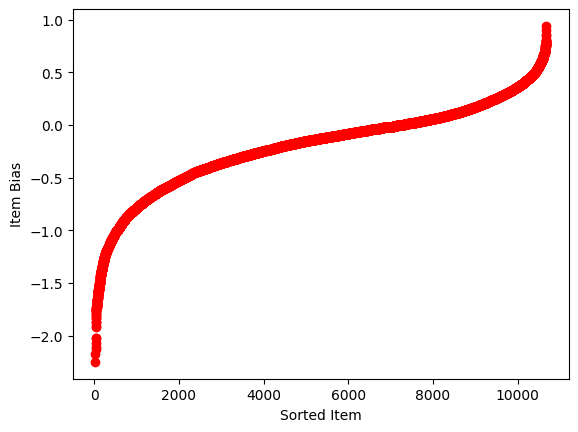

In [74]:
item_mean_rating = np.array(item_mean_rating).squeeze()
item_mean_rating = np.sort(item_mean_rating[item_mean_rating!=0])

pyplot.plot(item_mean_rating, 'ro')
pyplot.ylabel('Item Bias')
pyplot.xlabel('Sorted Item')
pyplot.show()

#### And the average rating for each user, or userBias

In [75]:
# This computes the mean of the row excluding the missing values
row_nnz = np.ediff1d(sps.csr_matrix(URM_train_unbiased).indptr)

# finally, let's compute the bias
user_mean_rating = URM_train_unbiased.sum(axis=1).ravel() / (row_nnz + lambda_user)
user_mean_rating = np.asarray(user_mean_rating).ravel()
user_mean_rating[row_nnz==0] = -np.inf
        
user_mean_rating

array([ 0.99163639, -0.10752725,  0.23389613, ...,  0.34226577,
        0.19485127, -0.19003633])

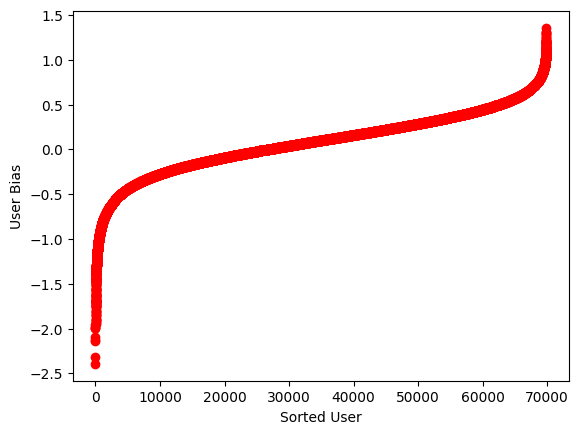

In [76]:
user_mean_rating = np.array(user_mean_rating).squeeze()
user_mean_rating = np.sort(user_mean_rating[user_mean_rating!=0.0])

pyplot.plot(user_mean_rating, 'ro')
pyplot.ylabel('User Bias')
pyplot.xlabel('Sorted User')
pyplot.show()

#### Now we can sort the items by their itemBias and use the same recommendation principle as in TopPop

In [77]:
class GlobalEffectsRecommender(object):

    def fit(self, URM_train, lambda_user=10, lambda_item=25):
        
        self.URM_train = URM_train

        # 1) global average
        self.mu = self.URM_train.data.sum(dtype=np.float32) / self.URM_train.nnz

        # 2) item average bias
        # compute the number of non-zero elements for each column
        col_nnz = np.ediff1d(sps.csc_matrix(self.URM_train).indptr)

        URM_train_unbiased = self.URM_train.copy()
        URM_train_unbiased.data -= self.mu
        
        item_bias = URM_train_unbiased.sum(axis=0) / (col_nnz + lambda_item)
        item_bias = np.asarray(item_bias).ravel()  # converts 2-d matrix to 1-d array without anycopy
        item_bias[col_nnz==0] = -np.inf 
        
        self.bestRatedItems = np.argsort(item_bias)
        self.bestRatedItems = np.flip(self.bestRatedItems, axis = 0)
        
    
    def recommend(self, user_id, at=5, remove_seen=True):

        if remove_seen:
            seen_items = self.URM_train.indices[self.URM_train.indptr[user_id]:self.URM_train.indptr[user_id+1]]
            
            unseen_items_mask = np.in1d(self.bestRatedItems, seen_items,
                                        assume_unique=True, invert = True)

            unseen_items = self.bestRatedItems[unseen_items_mask]

            recommended_items = unseen_items[0:at]

        else:
            recommended_items = self.bestRatedItems[0:at]
            

        return recommended_items



In [78]:
globalEffectsRecommender = GlobalEffectsRecommender()
globalEffectsRecommender.fit(URM_train)

evaluate_algorithm(URM_test, globalEffectsRecommender)

Recommender results are: Precision = 0.0793, Recall = 0.0196, MAP = 0.0569


#### GlobalEffects has a worse result than TopPop even though we are using "more" information.

### Let's see how TopPop accuracy changes by using only highly rated items to compute the popularity

In [79]:
for rating_threshold in range(0, 5):
    
    print("Removing ratings <= {}".format(rating_threshold))
    
    URM_train_filtered = URM_train.copy()
    URM_train_filtered.data[URM_train.data <= rating_threshold] = 0
    
    URM_train_filtered.eliminate_zeros()
    
    topPopRecommender = TopPopRecommender()
    topPopRecommender.fit(URM_train_filtered)
    
    evaluate_algorithm(URM_test, topPopRecommender)

Removing ratings <= 0
Recommender results are: Precision = 0.1983, Recall = 0.0534, MAP = 0.1473
Removing ratings <= 1
Recommender results are: Precision = 0.1950, Recall = 0.0529, MAP = 0.1434
Removing ratings <= 2
Recommender results are: Precision = 0.1882, Recall = 0.0519, MAP = 0.1360
Removing ratings <= 3
Recommender results are: Precision = 0.1610, Recall = 0.0462, MAP = 0.1086
Removing ratings <= 4
Recommender results are: Precision = 0.1235, Recall = 0.0383, MAP = 0.0749
